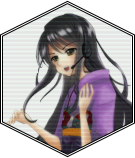

In [1]:
from IPython.display import Image, display
Image("ryoko.png", width="70")

# 료코 박사로 부터의 메시지
"*안녕하세요! 1-A에 이어서 이번주에 한가지 연습을 더 준비했습니다.<br/>
유명한 양자 알고리즘인 그로버 알고리즘에 초점을 맞춰보았어요.<br/>
앞으로 해결해 나가야 할 과제를 위해 꼭 필요한 지식이니까 열심히 해주세요! 행운을 빌어요!*"

# Week1-B: 그로버의 알고리즘

유명한 양자 알고리즘인 그로버 알고리즘에 대해서 배워봅시다. <br/> 물론, **이 튜토리얼의 마지막 부분에는 여러분을 위한 챌린지가 준비 되어 있습니다.** <br/>

고전 컴퓨터를 능가하는 양자 컴퓨터의 수 많은 가능성 중 하나로 빠른 속도로 데이터베이스를 검색하는 능력이 포함 된 다는것을 들어 본 적이 있나요?<br/>
그로버 알고리즘은 이 능력을 구현하는 알고리즘 입니다.  이 알고리즘은 검색을 2차 오더로 고속화(고전 알고리즘은 $N$ 번을 계산해야 하는 문제가 양자 컴퓨터로는 $\sqrt{N}$ 번만으로 구현 됨)할 수 있습니다, 하지만 단순히 검색에만 이용되는 것은 아닙니다; 2차 오더의 성능 개선이 필요한 다양한 알고리즘에 서브루틴이나 일반적인 용도로 사용될 수도 있습니다. 그로버 알고리즘은 일반적으로 진폭 증폭 기술로 불립니다. 

이 페이지에서는 검색 문제와 해당 알고리즘을 자세히 설명하고, 검색 문제용 오라클(Oracle)을 회로로 작성한 후 그로버의 알고리즘을 Qiskit을 이용하여 구현합니다. 


# 비정형 데이터 검색

$N$개의 데이터 목록이 제공된다고 가정합니다. 이 데이터들 중에서 우리가 찾고자 하는 독특한 특성을 가진 데이터가 하나 있습니다. 우리는 이것을 우승자 ${w}$ 라고 합시다. 목록에 있는 각 데이터를 박스안에 담겨있는 것으로 상상해 봅시다. 목록의 데이터는 우승자를 제외하고는 모두 회색 계열로 설정합시다. 

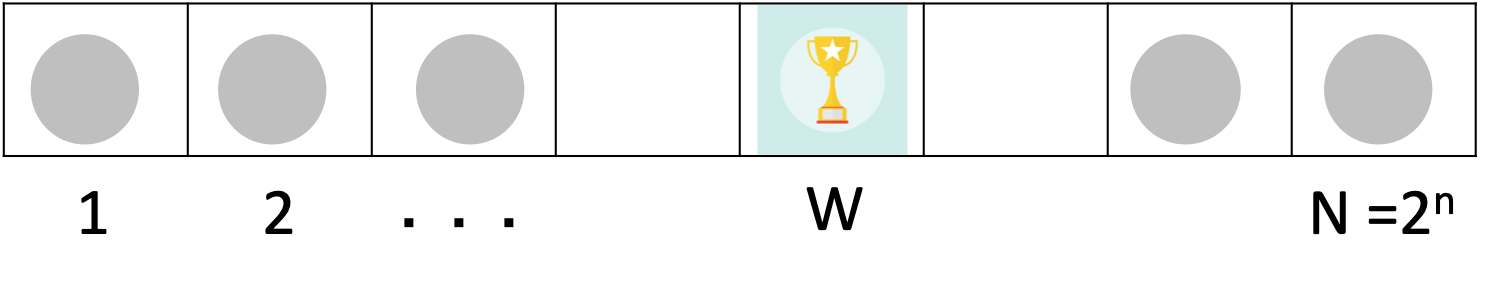

In [1]:
from IPython.display import Image, display
Image('unstructured_search.png', width="700")

우승자 -- 마크가 표시된 아이템 -- 를 찾기 위해서는 고전 계산에서는 평균 $N/2$개의 상자를 열어봐야 합니다.
최악의 경우, $N$ 개를 열어봐야합니다. 하지만 양자컴퓨터에서는 Grover의 진폭증폭 테크닉을 사용해서
대략 $\sqrt N$ 스텝에서 표시된 아이템을 찾을 수 있습니다.
2차 고속화는 큰 목록 내의 표시된 아이템을 찾기 위해서는 실제로는 많은 시간을 절약하게 해줍니다.
이 알고리즘은 목록 자체의 내부구조를 이용하지 않아 일반화될 수 있고 많은 고전의 문제에서도 2차 속도향상을 가져올 수 있습니다.

# 표시된 우승자를 찾기 위한 오라클
양자컴퓨터에 이런 리스트를 어떻게 제공하면 될까요? 이러한 리스트를 인코딩하기 위해 자주 이용되는 기법으로는 마크가 붙어 있지 않은 $x$에는 $f(x)=0$를 반환하고, 우승자 $w$에 대해서는 $f(w)=1$를 반환하는 함수 $f$를 정의하는 기법을 사용할 수 있습니다.이 문제에 대해 양자 컴퓨터를 사용하려면 이 함수에 대해 중첩된 상태의 아이템을 제공해야 합니다.즉, 이 함수를 오라클이라 불리는 유니터리 행렬로 인코딩해야 합니다.그러기 위해서 제일 먼저 아이템을 바이너리 표현으로 하겠습니다.즉, $x,w \in \{0,1\}^n$ 이고 $N=2^n$입니다.이렇게 하면 양자 컴퓨터상의 양자 비트로 표현할 수 있습니다.그런 다음 오라클 행렬 $U_w$를 임의의 표준 기저 $|x\rangle$에 대해 $U_w |x\rangle=(-1)^{f(x)}|x\rangle$가 되도록 정의합니다.

$x$가 표시되지 않은 아이템일 경우 오라클은 상태에 대해 아무것도 하지 않습니다. 하지만 우승자 상태 $|w\rangle$에 대해서 오라클을 적용하면 $U_w |w\rangle= -|w\rangle$에 매핑합니다.기하학적으로 이 유니터리 행렬은 $N=2^n$ 차원의 벡터 공간에서 마크된 아이템을 원점에 대해 반전시키는 동작을 수행합니다.

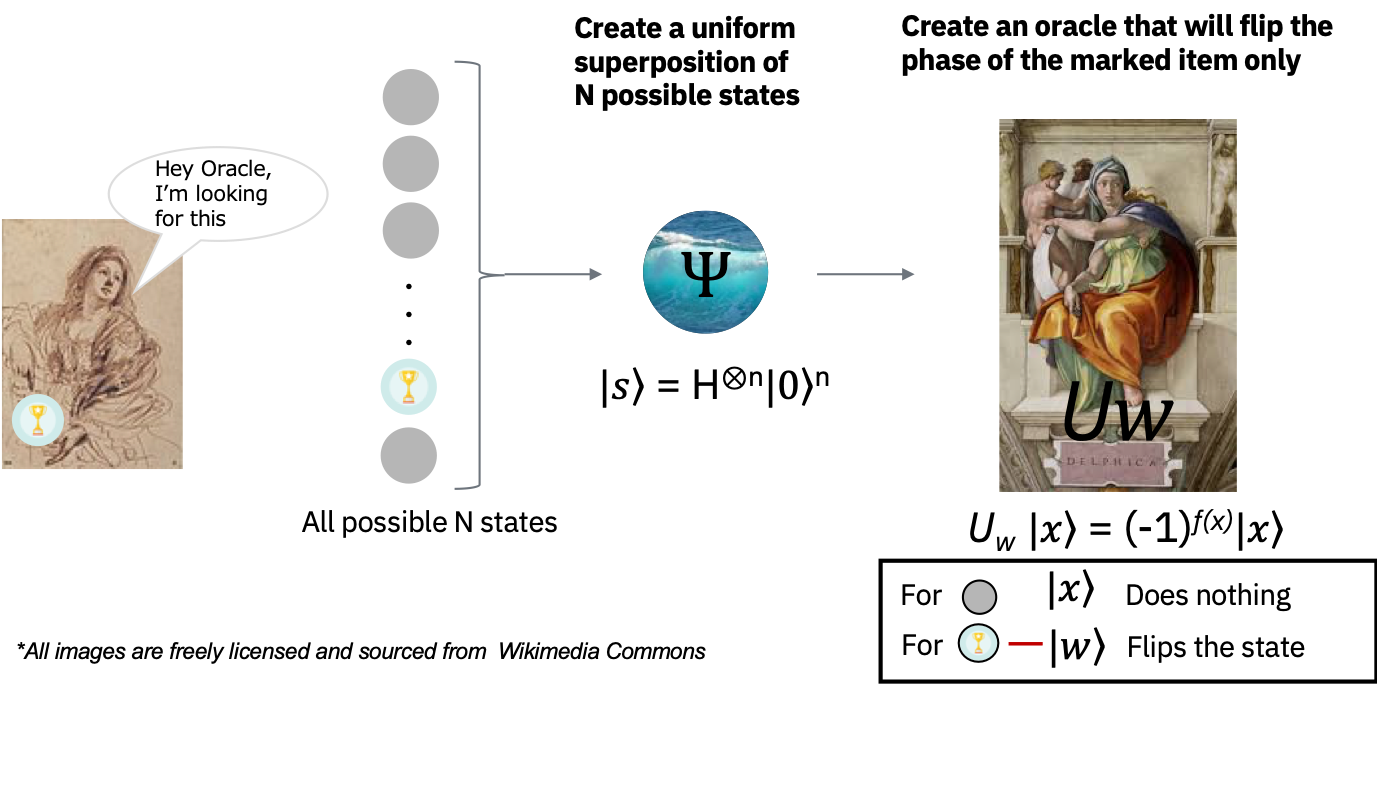

In [2]:
Image("oracle.png", width="700")

# 진폭 증폭

그럼 알고리즘은 어떻게 작동할까요? 목록을 알아보기 전에는 우리는 마크된 아이템이 어디에 있는지 모릅니다.따라서 아래 식으로 나타나는 균일한 중첩 상태입니다: 
$$|s\rangle = \frac{1}{\sqrt N}\sum_{x=0}^{N-1} |x\rangle $$

만약 이 시점에서 표준 기저 $|x\rangle $로 이 중첩 상태를 측정했을 경우, $\frac{1}{N} = \frac{1}{2^{n}} $ 의 확률로, 표준 기저 중 하나로 수렴합니다. 확률적으로 올바른 $|w\rangle$를 맞힐 확률은 $\frac{1}{2^{n}}$ 입니다.따라서 올바른 아이템을 추측하려면 평균 $N=2^{n}$회전이 필요합니다.


그래서 진폭증폭이라 불리는 단계를 시작합니다.이 과정에 의해, 양자 컴퓨터가 올바른 아이템을 찾아낼 확률을 큰폭으로 높일 수 있습니다.이 처리에서는 마크된 아이템의 진폭을 증폭하고 기타 아이템의 진폭을 줄입니다.이 결과 최종 상태를 측정하면 올바른 아이템을 거의 확실하게 찾아낼 수 있게 됩니다.

이 알고리즘에는 두 개의 반전이라는 재미있는 기하학적 해석이 있어 2차원 평면에서의 회전으로 나타낼 수 있습니다. 우리가 고려해야 할 것은 우승자 $|w\rangle$ 와 균일한 중첩 상태 $|s\rangle$의 특별한 두 가지 상태일 뿐입니다. 이 두 벡터는 벡터 공간 $\mathbb C^{N}$ 에서 2차원의 평면에 걸쳐있습니다. $|w\rangle$ 상태는 $N^{-1/2}$ 의 진폭으로 중첩되어 있기 때문에 이들 두 벡터가 완전히 직교하고 있는 것은 아닙니다.

하지만, $|s\rangle$에서 $|w\rangle$를 삭제하고 다시 정규화 함으로써 $|w\rangle$에 직교하는 추가 상태 $|s'\rangle$ 를 만들어 낼 수 있습니다.


**스텝 0** :

진폭 증폭은 균일한 중첩 상태 $|s\rangle$부터 시작합니다.균일한 중첩 상태는 $|s\rangle= H^{\otimes n}|0\rangle^{n}$로 쉽게 생성할 수 있습니다.$t=0$일 때 초기 상태는 $|\psi_{0}\rangle=|s\rangle$입니다.

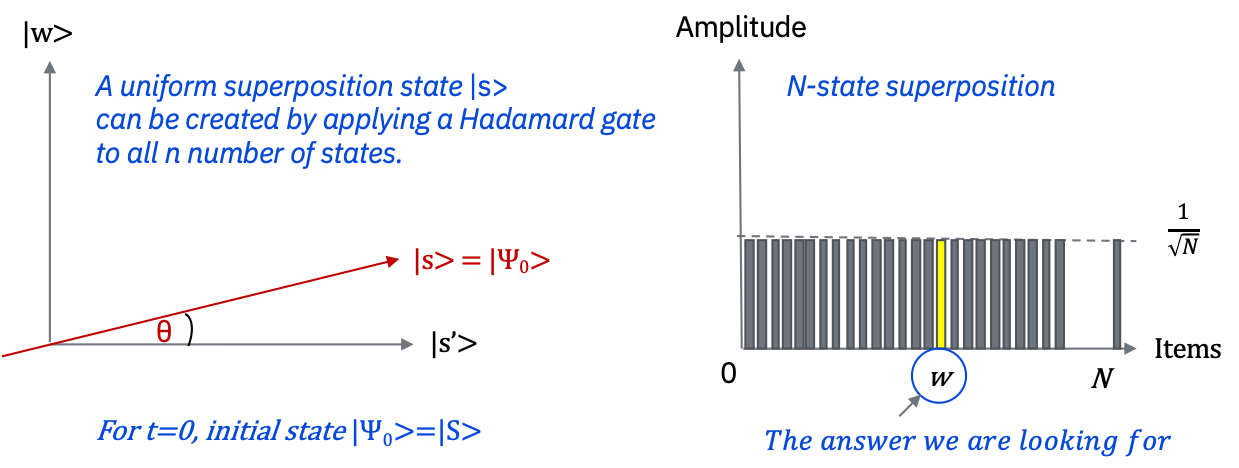

In [3]:
Image("step0.png", width="700")

왼쪽 그림은 $|w\rangle, |s'\rangle$에 의해서 구성되는 2차원 평면을 나타냅니다. 오른쪽 그림은 $N=2^n$일 경우의 상태 $|\psi_{t}\rangle$ 진폭을 나타내는 막대 그래프입니다.진폭의 평균치는 점선으로 표시되어 있습니다.

**스텝 1** :
반전 오라클 $U_{w}$를 상태에 적용합니다 $U_{w}|\psi_{t}\rangle=|\psi_{t'}\rangle $

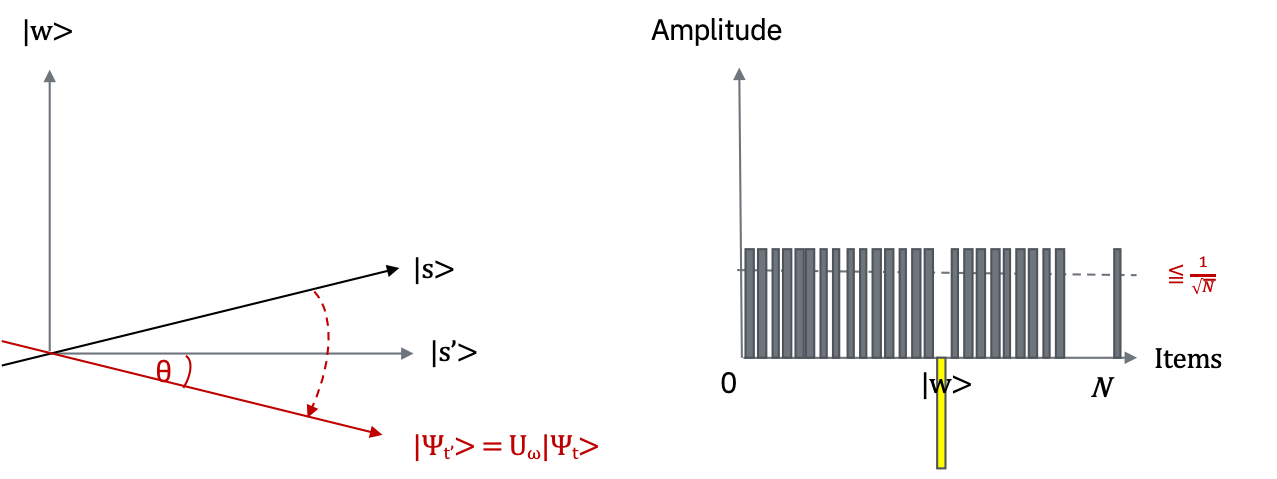

In [4]:
Image("step1.png", width="700")


기하학적으로는 상태 $|\psi_{t}\rangle$ 을 $|s'\rangle $에 대한 반전으로 나타나게 됩니다.이 변환이 의미하는 것은 $|w\rangle$ 상태의 진폭이 음의 값이 된다는 것으로, 결과적으로 평균 진폭이 낮아짐을 의미합니다.(오른쪽 그래프에서 점선이 내려가는 것을 주목해 주세요).

**스텝 2:**
다음 $|s\rangle$에 대한 추가 반전 $U_{s}$를 적용합니다.: $U_{s} = 2|s\rangle \langle s| - 1 $ 입니다.이 변환의 결과, 상태는 $U_{s}|\psi_{t'}\rangle$이고, 변환 $|\psi_{t+1}\rangle=U_{s}U_{w}|\psi_{t}\rangle$ 이 완료됩니다.(우측 그래프에서 $|w\rangle$에 대응하는 진폭이 증폭되고 있는 것을 유의 깊게 봐 주세요).

In [1]:
Image("step2.png", width="700")

NameError: name 'Image' is not defined

2개의 반전은 항상 회전과 대응됩니다.$U_{s}U_{w}$에 따른 변환은 초기 상태 $|s\rangle$를 우승자 $|w\rangle$에 접근하게 하는 회전입니다(Step2 왼쪽 그림 참조).$U_{s}$에 따른 반전 효과는 진폭 막대 그래프에서 평균 진폭에서의 반전으로 해석할 수 있습니다.첫 번째 반전으로 평균 진폭 값이 낮아졌으므로 이 변환은 음 진폭을 가진 $|w\rangle$를 원본 값에서 대략적으로 말해서 약 3배 정도 증폭하고 다른 진폭은 작게 합니다.그 후, **Step1**로 돌아가서 이것을 반복합니다. 우승자 $w$에 가까워질 때까지 이 과정을 여러번 반복하게 됩니다.

$t$회 반복 후, 상태는 $|\psi_{t}\rangle= (U_{s}U_{w})^{t}|\psi_{0}\rangle$로 나타나게 됩니다.


회전을 몇번 적용할 필요가 있을까요? 대략 $\sqrt N$ 회전이면 충분하다는 것을 알고 있습니다.이것은, 상태 $|\psi_{t}\rangle$의 진폭을 측정하면 확실해 집니다. $|w\rangle$ 의 진폭이 적용 횟수와 함께 선형적($ \sim tN^{1/2}$)으로 늘어나는 것을 알 수 있습니다.확률이 아니라 진폭을 다루고 있기 때문에 벡터 공간의 값에는 제곱근으로 들어갑니다.따라서 이 처리로 증폭되는 것은 단순한 확률이 아니라 진폭입니다.

만약 해가 여러 개, $M$개 있을 경우, 대략 $\sqrt{(N/M)}$ 회전이면 충분합니다.

In [2]:
Image("grover_algorithm.png", width="700")

NameError: name 'Image' is not defined

### Qiskit 적용: 두개의 큐빗을 사용한 그로버 알고리즘
자 이제, 그로버의 알고리즘을 Qiskit을 사용해 작성해 봅시다, 이 예제에서, 두개의 큐빗으로 $|11\rangle$ 상태를 검색핼 것입니다.

첫번째로 계산 환경을 준비합시다.

In [7]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

스텝 1에서 본것처럼, $|11\rangle$ 상태에 표시를 하는 위상(Phase) 오라클을 작성해 봅시다.

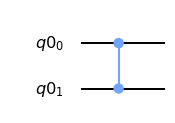

In [8]:
def phase_oracle(circuit, register):
    circuit.cz(register[0], register[1])

qr = QuantumRegister(2)
oracleCircuit = QuantumCircuit(qr)
phase_oracle(oracleCircuit, qr)
oracleCircuit.draw(output="mpl")

다음으로 Step2에서 실시한 평균에 대한 반전(inversion about averate)을 하는 회로를 작성합니다.이 회로는 Diffusion 회로로 불리기도 합니다.


In [9]:
def inversion_about_average(circuit, register):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[1])
    circuit.cx(register[0], register[1])
    circuit.h(register[1])
    circuit.x(register)
    circuit.h(register)

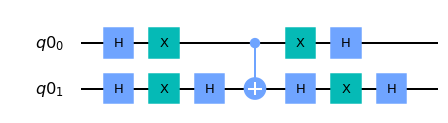

In [10]:
qAverage = QuantumCircuit(qr)
inversion_about_average(qAverage, qr)
qAverage.draw(output='mpl')

자 이제 모든 것을 하나로 모아봅시다. 회로의 처음에 균일한 중첩상태를 준비하고, 지금까지 작성한 부품을 합하여 마지막으로 측정을 실시합니다.네 가지 가능성 중 해는 하나이므로 반복 횟수는 한 번입니다.


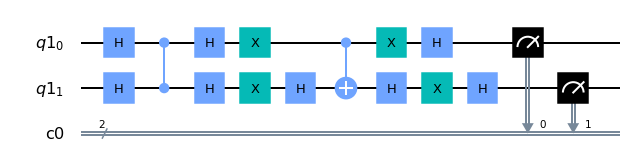

In [11]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

phase_oracle(groverCircuit, qr)
inversion_about_average(groverCircuit, qr)

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

### 시뮬레이터를 사용해서 실험해 봅시다
이제 위의 회로를 시뮬레이터로 계산해 봅시다.

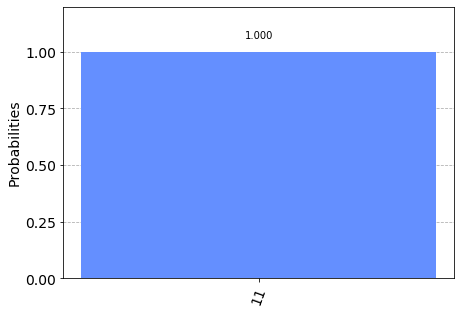

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

위에서 볼 수 있듯이, 알고리즘은 표시된 우승자 상태를 잘 찾아내고 있습니다.

### 실제 장비로 실험해 봅시다  
아래의 코드를 사용해서 회로를 실제 양자컴퓨터에서 실행시켜 볼 수 있습니다.


In [13]:
# Load our saved IBMQ accounts and get the least busy backend device

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend_lb = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
print("Least busy backend: ", backend_lb)

/Users/parton/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Least busy backend:  ibmq_valencia


In [14]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

Job Status: job has successfully run


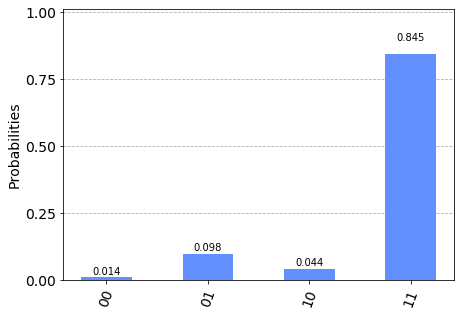

In [15]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)

### Qiskit 활용: 2 큐빗 그로버 알고리즘을 보조 비트를 사용해 작성하기
위와 마찬가지로 $|11\rangle$ 상태를 찾아내는 회로를 작성해 봅시다. 단 이번에는 보조 비트를 사용해 봅시다. 보조 비트는 더 많은 큐빗을 사용하게 해주고, 더 복잡한 오라클을 작성할 수 있게 합니다.

먼저 계산 환경을 설정합시다.

In [16]:
# Initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# Import basic plot tools
from qiskit.tools.visualization import plot_histogram


원하는 솔루션(이번 경우 $|11\rangle$)의 부호를 반전하는 오라클을 작성합니다.단, 이번에는 보조 양자 비트를 이용해 $|11\rangle$의 경우에 부호가 반전되도록 합니다.이 때 제대로 부호를 반전시키기 위해서는 사전에 보조비트를 $|1\rangle$로 해야 한다는 점을 주의해 주세요.

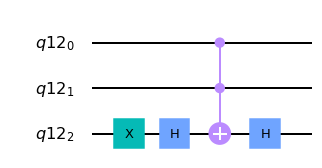

In [17]:
def phase_oracle(circuit, register,oracle_register):
    circuit.h(oracle_register)
    circuit.ccx(register[0], register[1],oracle_register)
    circuit.h(oracle_register)
    
qr = QuantumRegister(3)
oracleCircuit = QuantumCircuit(qr)
oracleCircuit.x(qr[2])
phase_oracle(oracleCircuit, qr,qr[2])
oracleCircuit.draw(output="mpl")

다음으로 Diffusion 회로를 준비합니다. Diffusion 회로는 보조비트에 작용하지 않습니다. 주의하십시오.

In [18]:
def inversion_about_average(circuit, register):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[1])
    circuit.cx(register[0], register[1])
    circuit.h(register[1])
    circuit.x(register)
    circuit.h(register)

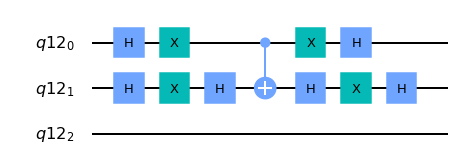

In [19]:
qAverage = QuantumCircuit(qr)
inversion_about_average(qAverage, qr[0:2])
qAverage.draw(output='mpl')


보조비트 없이 작성한 회로와 마찬가지로 회로의 처음에 균일한 중첩상태를 작성하고(이 때 보조비트에 H게이트를 적용하지 않도록 주의하십시오), 변환을 적용하고 마지막으로 측정을 합니다.


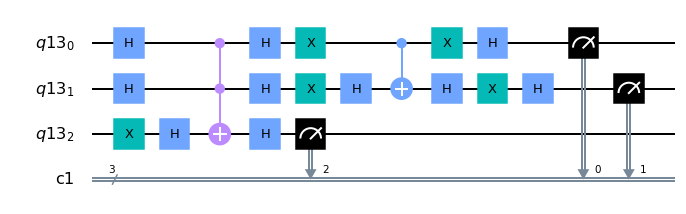

In [20]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr[0:2])
groverCircuit.x(qr[2])

phase_oracle(groverCircuit, qr,qr[2])
inversion_about_average(groverCircuit, qr[0:2])

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

### 시뮬레이터로 계산해 보기
이제 회로를 시뮬레이터에서 실행시켜 봅시다. 'qasm_simulator'를 벡엔드로 지정하세요.

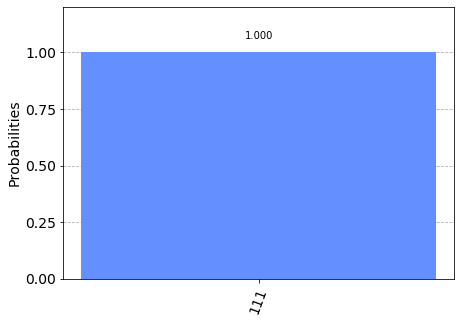

In [21]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)


보조비트 없이 작성한 회로와 같이 $|11\rangle$ 상태일 확률이 증폭되고 있는 것을 확인할 수 있습니다. 최상위 비트 - 1은 보조 양자 비트이므로 무시해도 좋습니다.


## 팁: 반복 횟수

글로버의 알고리즘은 해가 완전히 증폭될 때까지 약 $\sqrt{N}$회 반복한다고 했는데, 가장 해가 커지는 반복 횟수를 생각해 보겠습니다.

예를 들어, $N=2^4$ 데이터베이스에서 글로버 알고리즘을 실행시킬 때 해당 횟수의 측정 확률은 다음과 같이 반복 횟수에 따라 달라집니다.

In [3]:
backend = BasicAer.get_backend('qasm_simulator')
prob_of_ans = []

for x in range(12):
    database = QuantumRegister(4)
    oracle = QuantumRegister(1)
    auxiliary = QuantumRegister(2) 
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(database, oracle, auxiliary, cr)
    qc.h(database[:])
    qc.x(oracle[0])
    qc.h(oracle[0])


    for j in range(x):
    # oracle_4q
        # search 7: 0111 
        qc.x(database[0])
        qc.mct(database[:], oracle[0], auxiliary[:], mode='basic') 
        qc.x(database[0])

    # diffusion_4q
        qc.h(database[:])
        qc.x(database[:])
        qc.h(database[3])
        qc.mct(database[0:3], database[3], auxiliary[:], mode='basic')
        qc.h(database[3])
        qc.x(database[:])
        qc.h(database[:])


    qc.h(oracle[0])
    qc.x(oracle[0])
    qc.measure(database,cr)
    # Change the endian 
    qc = qc.reverse_bits() 
    
    job = execute(qc, backend=backend, shots=1000, seed_simulator=12345, backend_options={"fusion_enable":True})
    result = job.result()
    count = result.get_counts()
    answer = count['0111']
    prob_of_ans.append(answer)

NameError: name 'BasicAer' is not defined

Text(0, 0.5, '# of times the solution was obtained')

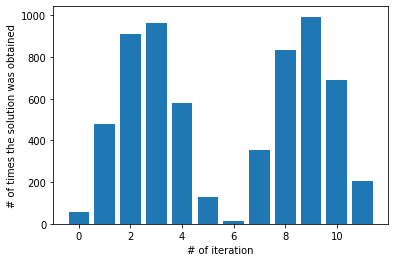

In [23]:
import numpy as np
import matplotlib.pyplot as plt
iteration = [i for i in range(12)]
correct = prob_of_ans
plt.bar(iteration, correct)
plt.xlabel('# of iteration')
plt.ylabel('# of times the solution was obtained')

# 연습 과제 I-B
$N = 2 ^7$ 크기의 데이터베이스에서 글로버 알고리즘을 실행해 1개의 아이템을 찾을 때 최대 진폭을 얻는 반복 횟수를 답하시오. 위의 예에서 보셨듯이 반복 횟수를 바꿔 진폭을 알아보십시오.답은 정수여야 합니다.

힌트 : 답은 15회 이하입니다.

In [ ]:
# Change ans of following code and check your answer.
# ans must be an interger.

from qc_grader import grade_ex1b
grade_ex1b(ans)

In [ ]:
# Change ans of following code and submit it.
# ans must be interger.

from qc_grader import submit_ex1b
submit_ex1b(ans)